# 1.9j: Dimension Projections for Local Neighborhood

From 1.9i we know the local neighborhood spans different extents in different dimensions.

**Question:** What does the structure look like when projected onto a single dimension's axis?

**Method:**
1. Load the 52 unique vectors (13 BH centroids + 39 singletons) in uint16 representation
2. For a chosen dimension, decode the bfloat16 components into sign/exponent/mantissa
3. **Top plot**: Show unique vectors as points on a mantissa number line
   - Singletons: white dots with black outline
   - Black holes: color-coded by BH ID (0-12)
   - Integer tick marks showing the quantum lattice
4. **Bottom plot**: Histogram showing population (number of tokens) at each mantissa value
   - Log y-axis to handle BH populations (hundreds) vs singleton populations (1)

**Parameterized by DIMENSION** so we can explore any dimension.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Dimension to visualize (can change this to explore different dimensions)
DIMENSION = 61

# Active dimensions from 1.9c (for reference)
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

# Visualization parameters
DPI = 150
FIGSIZE = (14, 8)

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict, Counter

## Load Data

In [3]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [4]:
# Load black hole data from 1.9b
bh_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
bh_data = load_file(bh_path)

core_token_ids = bh_data["core_token_ids"].to(torch.int64)
bh_labels = bh_data["bh_labels"].to(torch.int64)
n_black_holes = bh_data["n_black_holes"].item()

print(f"\nLoaded black hole data: {n_black_holes} black holes")


Loaded black hole data: 13 black holes


In [5]:
# Load neighborhood data from 1.9g
nbhd_path = Path(f"../tensors/{MODEL_NAME}/1.9g_local_neighborhood.safetensors")
nbhd_data = load_file(nbhd_path)

full_neighborhood_token_ids = nbhd_data["full_neighborhood_token_ids"].to(torch.int64)
n_full_neighborhood = nbhd_data["n_full_neighborhood"].item()

print(f"\nLoaded neighborhood: {n_full_neighborhood:,} tokens")


Loaded neighborhood: 2,139 tokens


## Extract Unique Vectors and Categorize

In [6]:
print("\nExtracting unique vectors...\n")

# Get all vectors in the neighborhood
neighborhood_vectors_bf16 = W_bf16[full_neighborhood_token_ids]

# Convert to uint16 for exact comparison
neighborhood_vectors_uint16 = neighborhood_vectors_bf16.cpu().view(torch.uint16).numpy()

# Find unique vectors and inverse mapping
unique_vectors, first_occurrence_idx, inverse_mapping = np.unique(
    neighborhood_vectors_uint16, 
    axis=0, 
    return_index=True, 
    return_inverse=True
)

n_unique = len(unique_vectors)

print(f"✓ Found {n_unique} unique vectors")
print()

# Build mapping: unique_idx -> list of token IDs with that vector
unique_to_tokens = defaultdict(list)
for token_idx, unique_idx in enumerate(inverse_mapping):
    token_id = full_neighborhood_token_ids[token_idx].item()
    unique_to_tokens[unique_idx].append(token_id)

# Categorize each unique vector as BH (and which BH) or singleton
bh_token_ids_set = set(core_token_ids[bh_labels >= 0].tolist())

# Map token_id -> BH ID for BH tokens
token_to_bh_id = {}
for i, token_id in enumerate(core_token_ids):
    bh_id = bh_labels[i].item()
    if bh_id >= 0:
        token_to_bh_id[token_id.item()] = bh_id

# For each unique vector, determine if it's a BH and which one
unique_types = []  # 'BH' or 'singleton'
unique_bh_ids = []  # BH ID (0-12) if BH, else None
unique_populations = []  # How many tokens

for unique_idx in range(n_unique):
    token_ids_for_this_vector = unique_to_tokens[unique_idx]
    unique_populations.append(len(token_ids_for_this_vector))
    
    # Check if any token is a BH
    bh_ids_for_this_vector = [token_to_bh_id[tid] for tid in token_ids_for_this_vector if tid in token_to_bh_id]
    
    if bh_ids_for_this_vector:
        # This is a BH centroid
        unique_types.append('BH')
        # All tokens with this vector should have same BH ID
        unique_bh_ids.append(bh_ids_for_this_vector[0])
    else:
        # This is a singleton
        unique_types.append('singleton')
        unique_bh_ids.append(None)

n_unique_bh = sum(1 for t in unique_types if t == 'BH')
n_unique_singleton = sum(1 for t in unique_types if t == 'singleton')

print(f"Unique vector breakdown:")
print(f"  Black hole centroids: {n_unique_bh}")
print(f"  Singleton vectors: {n_unique_singleton}")


Extracting unique vectors...

✓ Found 52 unique vectors

Unique vector breakdown:
  Black hole centroids: 13
  Singleton vectors: 39


## Decode bfloat16 Components for Target Dimension

In [7]:
print(f"\nAnalyzing dimension {DIMENSION}...\n")

# Extract uint16 values for this dimension
dim_values_uint16 = unique_vectors[:, DIMENSION]

# Decode bfloat16 components
def decode_bfloat16(value_uint16):
    """Decode uint16 into sign, exponent, mantissa."""
    bits_binary = format(value_uint16, '016b')
    sign = int(bits_binary[0])
    exponent = int(bits_binary[1:9], 2)
    mantissa = int(bits_binary[9:16], 2)
    return sign, exponent, mantissa

signs = []
exponents = []
mantissas = []

for val in dim_values_uint16:
    s, e, m = decode_bfloat16(val)
    signs.append(s)
    exponents.append(e)
    mantissas.append(m)

# Check if all have same exponent (they should in exponent-matched neighborhood)
unique_exponents = set(exponents)
if len(unique_exponents) == 1:
    common_exponent = list(unique_exponents)[0]
    print(f"✓ All vectors share exponent {common_exponent} in dimension {DIMENSION}")
else:
    print(f"⚠ Multiple exponents found: {unique_exponents}")
    common_exponent = max(set(exponents), key=exponents.count)
    print(f"  Using most common exponent: {common_exponent}")

print()

# Compute extent
min_mantissa = min(mantissas)
max_mantissa = max(mantissas)
extent = max_mantissa - min_mantissa

print(f"Mantissa range: [{min_mantissa}, {max_mantissa}]")
print(f"Extent: {extent} steps")
print()

# Count unique mantissas
unique_mantissas = sorted(set(mantissas))
print(f"Unique mantissa values: {len(unique_mantissas)}")
print(f"  Values: {unique_mantissas}")


Analyzing dimension 61...

✓ All vectors share exponent 115 in dimension 61

Mantissa range: [37, 38]
Extent: 1 steps

Unique mantissa values: 2
  Values: [37, 38]


## Prepare Data for Plotting

In [8]:
# Separate by type for plotting
singleton_mantissas = [mantissas[i] for i in range(n_unique) if unique_types[i] == 'singleton']
singleton_populations = [unique_populations[i] for i in range(n_unique) if unique_types[i] == 'singleton']

# Group BHs by BH ID
bh_mantissas_by_id = defaultdict(list)
bh_populations_by_id = defaultdict(list)

for i in range(n_unique):
    if unique_types[i] == 'BH':
        bh_id = unique_bh_ids[i]
        bh_mantissas_by_id[bh_id].append(mantissas[i])
        bh_populations_by_id[bh_id].append(unique_populations[i])

# Build histogram data (mantissa -> total population)
mantissa_population = Counter()
for i in range(n_unique):
    mantissa_population[mantissas[i]] += unique_populations[i]

print(f"\nData prepared for plotting:")
print(f"  Singleton points: {len(singleton_mantissas)}")
print(f"  BH centroids: {len(bh_mantissas_by_id)} distinct BHs")
print(f"  Histogram bins: {len(mantissa_population)}")


Data prepared for plotting:
  Singleton points: 39
  BH centroids: 13 distinct BHs
  Histogram bins: 2


## Visualization


Creating visualization...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_59497/364116276.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 13)


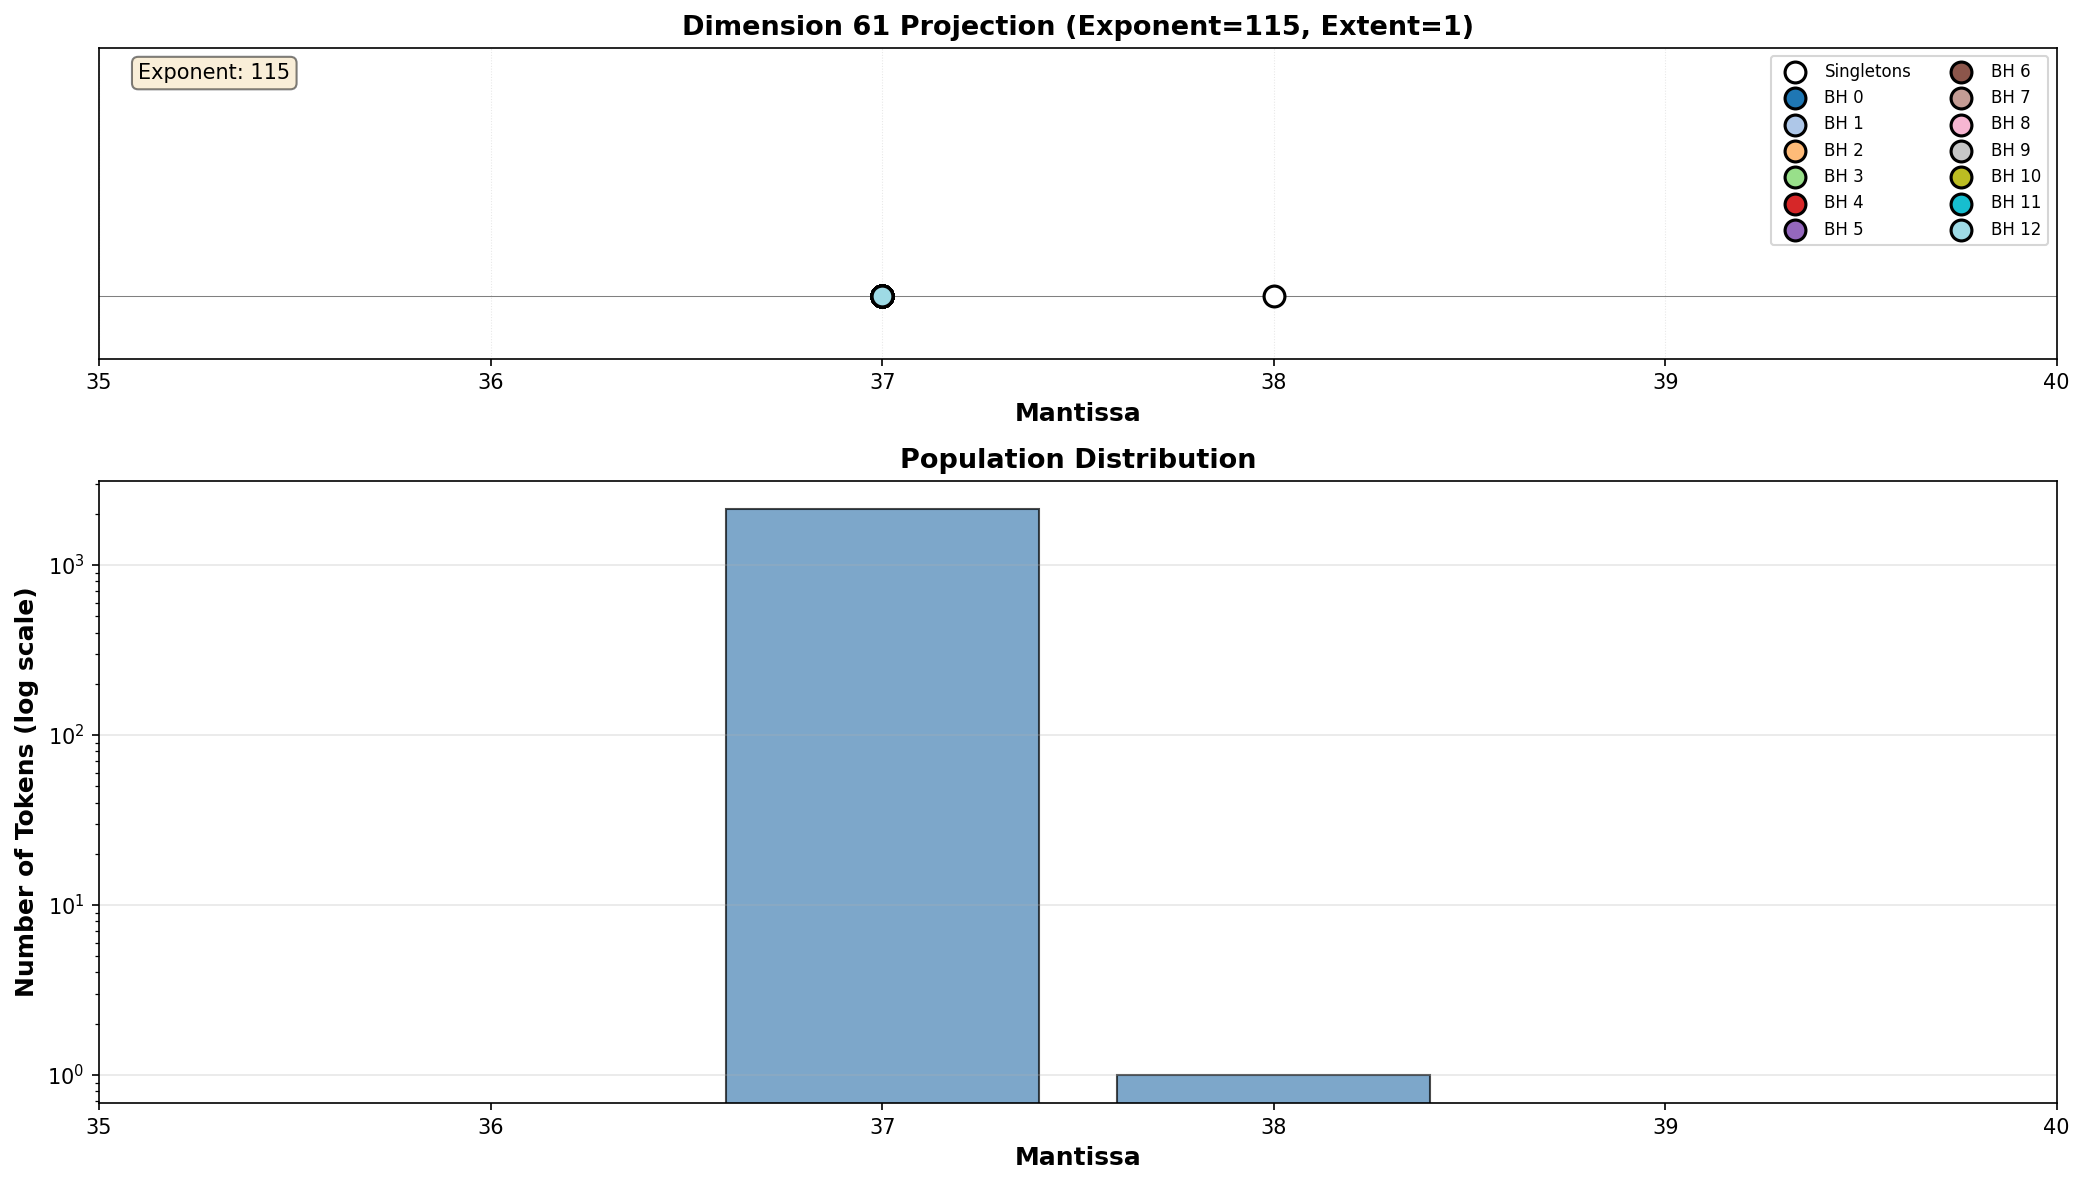

✓ Visualization complete


In [9]:
print("\nCreating visualization...\n")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGSIZE, dpi=DPI, 
                                gridspec_kw={'height_ratios': [1, 2]})

# === TOP PLOT: Unique vectors on mantissa number line ===

# Set up x-axis range with a little padding
x_min = min_mantissa - 2
x_max = max_mantissa + 2

# Plot singletons (white with black outline)
if singleton_mantissas:
    ax1.scatter(singleton_mantissas, [0] * len(singleton_mantissas), 
                s=100, c='white', edgecolors='black', linewidths=1.5, 
                zorder=10, label='Singletons')

# Plot BH centroids (color-coded by BH ID)
# Use a colormap with 13 distinct colors
cmap = plt.cm.get_cmap('tab20', 13)
for bh_id in sorted(bh_mantissas_by_id.keys()):
    mantissas_for_bh = bh_mantissas_by_id[bh_id]
    color = cmap(bh_id)
    ax1.scatter(mantissas_for_bh, [0] * len(mantissas_for_bh),
                s=100, c=[color], edgecolors='black', linewidths=1.5,
                zorder=10, label=f'BH {bh_id}')

# Draw integer tick marks for quantum lattice
tick_positions = range(x_min, x_max + 1)
ax1.set_xticks(tick_positions)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(-0.5, 2.0)

# Style
ax1.set_xlabel('Mantissa', fontsize=12, fontweight='bold')
ax1.set_yticks([])
ax1.axhline(0, color='gray', linewidth=0.5, linestyle='-', zorder=1)
ax1.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
ax1.set_title(f'Dimension {DIMENSION} Projection (Exponent={common_exponent}, Extent={extent})', 
              fontsize=13, fontweight='bold')

# Legend (only if there aren't too many BHs)
if len(bh_mantissas_by_id) <= 13:
    ax1.legend(loc='upper right', fontsize=8, ncol=2)

# Add exponent annotation in corner
ax1.text(0.02, 0.95, f'Exponent: {common_exponent}', 
         transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === BOTTOM PLOT: Histogram of populations ===

# Prepare histogram data
hist_mantissas = sorted(mantissa_population.keys())
hist_populations = [mantissa_population[m] for m in hist_mantissas]

# Bar chart
ax2.bar(hist_mantissas, hist_populations, width=0.8, 
        edgecolor='black', alpha=0.7, color='steelblue')

# Same x-axis as top plot
ax2.set_xlim(x_min, x_max)
ax2.set_xticks(tick_positions)

# Log y-axis to handle BH populations vs singletons
ax2.set_yscale('log')
ax2.set_xlabel('Mantissa', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Tokens (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('Population Distribution', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary

In [10]:
print("\n" + "=" * 100)
print(f"SUMMARY: DIMENSION {DIMENSION} PROJECTION")
print("=" * 100)
print()

print(f"Dimension: {DIMENSION}")
print(f"  In known active dims: {'✓' if DIMENSION in ACTIVE_DIMS else '✗'}")
print()

print(f"Structure:")
print(f"  Exponent: {common_exponent} (shared by all {n_unique} unique vectors)")
print(f"  Mantissa range: [{min_mantissa}, {max_mantissa}]")
print(f"  Extent: {extent} uint16 steps")
print(f"  Unique mantissa values: {len(unique_mantissas)}")
print()

print(f"Composition:")
print(f"  BH centroids: {n_unique_bh} unique positions")
print(f"  Singleton vectors: {n_unique_singleton} unique positions")
print()

print(f"Population:")
print(f"  Total tokens: {sum(unique_populations):,}")
print(f"  BH tokens: {sum(p for i, p in enumerate(unique_populations) if unique_types[i] == 'BH'):,}")
print(f"  Singleton tokens: {sum(p for i, p in enumerate(unique_populations) if unique_types[i] == 'singleton'):,}")
print()

# Check if BHs and singletons overlap in mantissa space
bh_mantissa_set = set(m for i, m in enumerate(mantissas) if unique_types[i] == 'BH')
singleton_mantissa_set = set(m for i, m in enumerate(mantissas) if unique_types[i] == 'singleton')
overlap = bh_mantissa_set & singleton_mantissa_set

if overlap:
    print(f"⚠ OVERLAP DETECTED")
    print(f"  {len(overlap)} mantissa values occupied by both BHs and singletons: {sorted(overlap)}")
else:
    print(f"✓ NO OVERLAP")
    print(f"  BH centroids and singleton vectors occupy disjoint mantissa values.")

print()
print("=" * 100)


SUMMARY: DIMENSION 61 PROJECTION

Dimension: 61
  In known active dims: ✗

Structure:
  Exponent: 115 (shared by all 52 unique vectors)
  Mantissa range: [37, 38]
  Extent: 1 uint16 steps
  Unique mantissa values: 2

Composition:
  BH centroids: 13 unique positions
  Singleton vectors: 39 unique positions

Population:
  Total tokens: 2,139
  BH tokens: 2,100
  Singleton tokens: 39

⚠ OVERLAP DETECTED
  1 mantissa values occupied by both BHs and singletons: [37]

